In [21]:
import numpy as np
import pandas as pd

import spateo as st
import dynamo as dyn

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import isspmatrix

to_dense_matrix = lambda X: np.array(X.todense()) if isspmatrix(X) else np.asarray(X)

# st.configuration.set_pub_style_mpltex()
# %matplotlib inline

In [14]:
# Load annotated binning data
fname_bin60 = "mousebrain_bin60_clustered.h5ad"
adata_bin60 = st.sample_data.mousebrain(fname_bin60)

# Load annotated cellbin data
fname_cellbin = "mousebrain_cellbin_clustered.h5ad"
adata_cellbin = st.sample_data.mousebrain(fname_cellbin)

adata_bin60, adata_cellbin

|-----> Downloading data to ./data/mousebrain_bin60_clustered.h5ad
https://www.dropbox.com/s/wxgkim87uhpaz1c/mousebrain_bin60_clustered.h5ad?dl=1
|-----> [download] in progress: 100.0000%
|-----> [download] finished [1913.1506s]
|-----> Downloading data to ./data/mousebrain_cellbin_clustered.h5ad


(AnnData object with n_obs × n_vars = 7765 × 21667
     obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size', 'louvain', 'scc', 'scc_anno'
     var: 'pass_basic_filter'
     uns: '__type', 'louvain', 'louvain_colors', 'neighbors', 'pp', 'scc', 'scc_anno_colors', 'scc_colors', 'spatial', 'spatial_neighbors'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
     layers: 'count', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances',
 AnnData object with n_obs × n_vars = 11854 × 14645
     obs: 'area', 'pass_basic_filter', 'n_counts', 'louvain', 'Celltype'
     var: 'mt', 'pass_basic_filter'
     uns: 'Celltype_colors', '__type', 'louvain', 'neighbors', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
     layers: 'count', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances')

# Transfer domain annotation to cells

将adata_bin60域注释转移到adata_cellbin上

In [ ]:
# Extract spatial domains from SCC clusters.
# Transfer domain annotation to cells.
st.dd.set_domains(
    adata_high_res=adata_cellbin,
    adata_low_res=adata_bin60,
    bin_size_high=1,
    bin_size_low=60,
    cluster_key="scc_anno",
    domain_key_prefix="transfered_domain",
    k_size=1.8,
    min_area=16,
)

In [17]:
adata_cellbin

AnnData object with n_obs × n_vars = 11854 × 14645
    obs: 'area', 'pass_basic_filter', 'n_counts', 'louvain', 'Celltype', 'transfered_domain_scc_anno'
    var: 'mt', 'pass_basic_filter'
    uns: 'Celltype_colors', '__type', 'louvain', 'neighbors', 'spatial', 'transfered_domain_scc_anno_colors'
    obsm: 'X_pca', 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'count', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

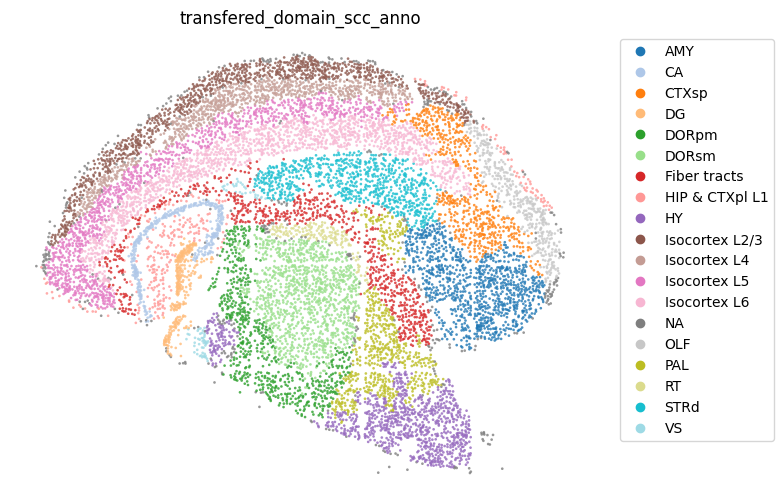

In [16]:
# View cell domain
st.pl.space(
    adata_cellbin,
    color=['transfered_domain_scc_anno'],
    pointsize=0.1,
    show_legend="upper left",
    figsize=(8, 6),
    color_key_cmap = "tab20",
)

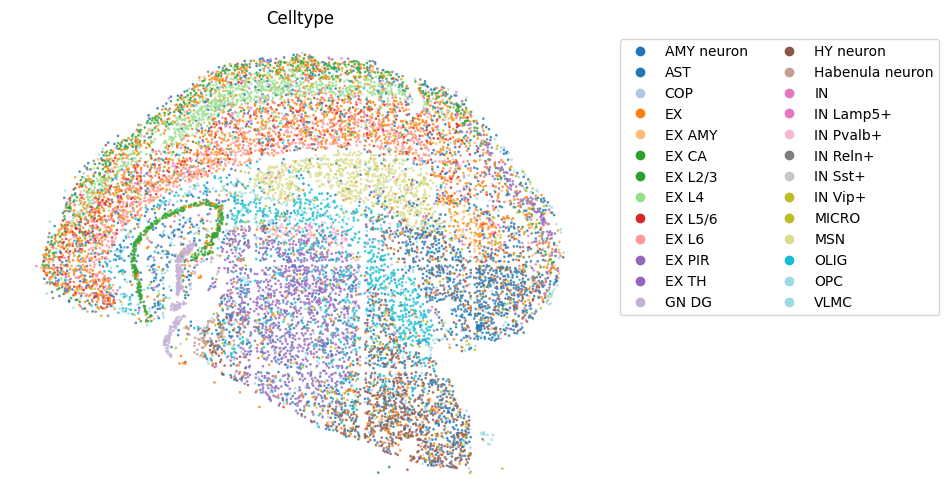

In [18]:
# View cell domain
st.pl.space(
    adata_cellbin,
    color=['Celltype'],
    pointsize=0.1,
    show_legend="upper left",
    figsize=(8, 6),
    color_key_cmap = "tab20",
)

# Cell-Domain specificity and heterogeneity

In [23]:
# Summary domain-cell relationship
domain_list = np.array([])
celltype_list = np.array([])
count_list = np.array([])
for i in np.unique(adata_cellbin.obs['transfered_domain_scc_anno']):
    tmp, counts = np.unique(adata_cellbin[adata_cellbin.obs['transfered_domain_scc_anno'] == i,:].obs['Celltype'], return_counts=True)
    domain_list = np.append(domain_list, np.repeat(i, len(counts)))
    celltype_list = np.append(celltype_list, tmp)
    count_list = np.append(count_list, counts)
hetero_df = pd.DataFrame({"domain":domain_list, "celltype":celltype_list, "count":count_list.astype(int)})

In [25]:
np.unique(adata_cellbin.obs['transfered_domain_scc_anno'])

array(['AMY', 'CA', 'CTXsp', 'DG', 'DORpm', 'DORsm', 'Fiber tracts',
       'HIP & CTXpl L1', 'HY', 'Isocortex L2/3', 'Isocortex L4',
       'Isocortex L5', 'Isocortex L6', 'NA', 'OLF', 'PAL', 'RT', 'STRd',
       'VS'], dtype=object)

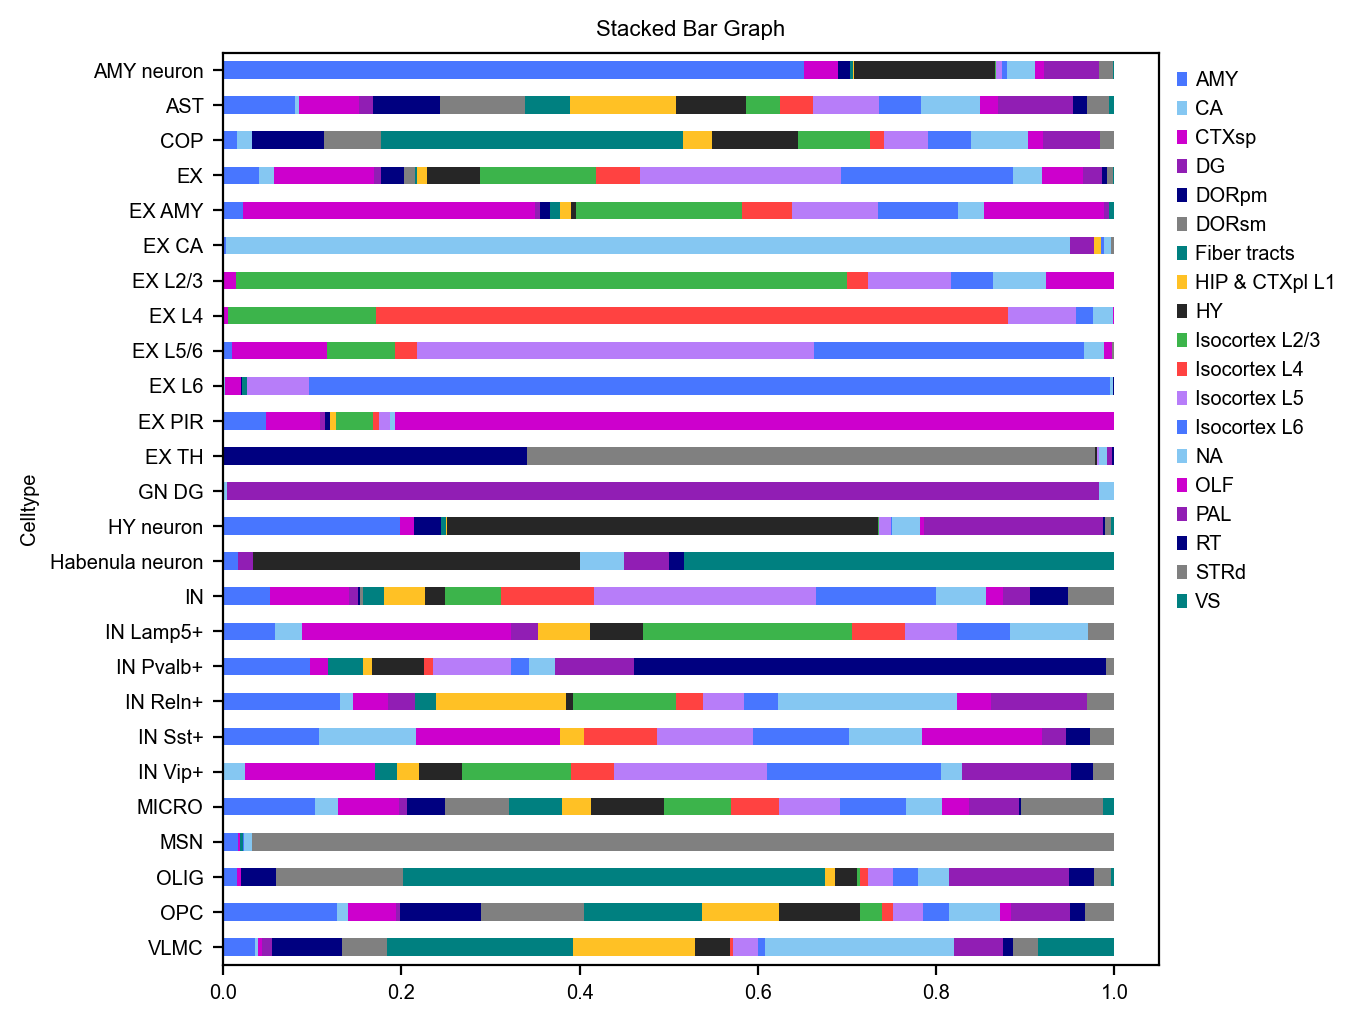

In [36]:
# Cell distribution among domains
spec_df_plt = hetero_df.pivot(index="celltype", columns="domain", values="count").fillna(0)
spec_df_plt = spec_df_plt.div(spec_df_plt.sum(axis=1), axis=0)

spec_df_plt['Celltype'] = spec_df_plt.index
spec_df_plt.index = pd.CategoricalIndex(spec_df_plt.index, categories=spec_df_plt.index.astype(str).sort_values())
spec_df_plt = spec_df_plt.sort_index(ascending=False)

spec_df_plt.plot(
    x = 'Celltype',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True,
    figsize=(6, 6),
    legend = True,

).legend(
    bbox_to_anchor=(1.0, 1.0),
    frameon = False,
)

In [39]:
hetero_df

,domain,celltype,count
0,AMY,AMY neuron,418
1,AMY,AST,98
2,AMY,COP,1
3,AMY,EX,70
4,AMY,EX AMY,4
...,...,...,...
315,VS,HY neuron,4
316,VS,Habenula neuron,29
317,VS,MICRO,6
318,VS,OLIG,4


In [38]:
hetero_df.pivot(index="celltype", columns="domain", values="count").fillna(0)

domain,AMY,CA,CTXsp,DG,DORpm,DORsm,Fiber tracts,HIP & CTXpl L1,HY,Isocortex L2/3,Isocortex L4,Isocortex L5,Isocortex L6,NA,OLF,PAL,RT,STRd,VS
celltype,,,,,,,,,,,,,,,,,,,
AMY neuron,418.0,0.0,24.0,0.0,9.0,0.0,2.0,1.0,101.0,1.0,0.0,4.0,4.0,20.0,6.0,40.0,0.0,10.0,1.0
AST,98.0,6.0,81.0,19.0,92.0,115.0,62.0,144.0,95.0,46.0,46.0,89.0,57.0,81.0,25.0,101.0,20.0,30.0,7.0
COP,1.0,1.0,0.0,0.0,5.0,4.0,21.0,2.0,6.0,5.0,1.0,3.0,3.0,4.0,1.0,4.0,0.0,1.0,0.0
EX,70.0,31.0,197.0,14.0,46.0,20.0,4.0,21.0,104.0,230.0,86.0,398.0,339.0,56.0,81.0,39.0,9.0,13.0,2.0
EX AMY,4.0,0.0,58.0,1.0,2.0,0.0,2.0,2.0,1.0,33.0,10.0,17.0,16.0,5.0,24.0,1.0,0.0,0.0,1.0
EX CA,1.0,248.0,0.0,7.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0
EX L2/3,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,332.0,11.0,45.0,23.0,29.0,37.0,0.0,0.0,0.0,0.0
EX L4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,502.0,54.0,14.0,16.0,1.0,0.0,0.0,0.0,0.0
EX L5/6,4.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,10.0,183.0,124.0,9.0,4.0,0.0,0.0,1.0,0.0


<Axes: xlabel='domain', ylabel='celltype'>

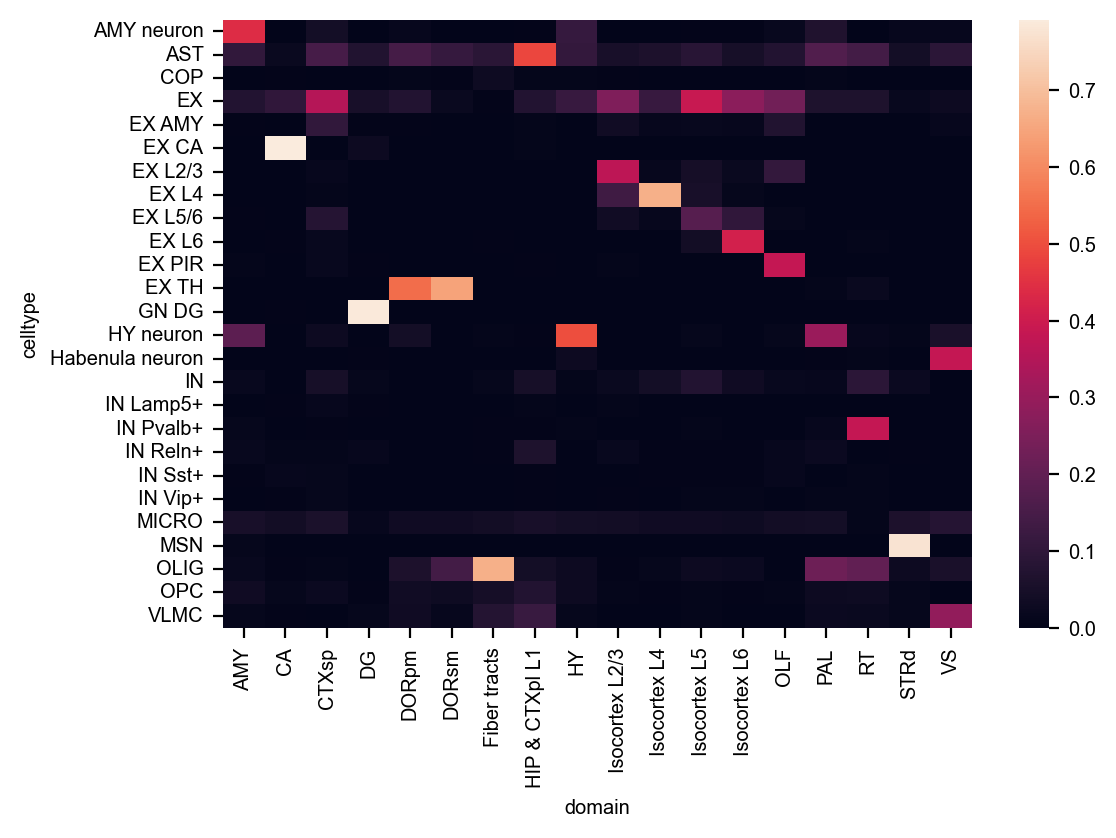

In [37]:
# Cell composition within each domain
hetero_df_plt = hetero_df[hetero_df.domain!="NA"].pivot(index="domain", columns="celltype", values="count").fillna(0)
hetero_df_plt = hetero_df_plt.div(hetero_df_plt.sum(axis=1), axis=0)

sns.heatmap(hetero_df_plt.T)

# Celltype spatial distribution

In [42]:
# Celltype co-localization (OPC and others)
# Doing dyn.tl.neighbors for N times is easy but time comsuming. (One time is enough, to be optimized soon)
# Should hide the logging of this codeblock (neighbor finding outputs too much log)

celltype_of_interest = "OPC"

n_neigh = []
neigh_type = []
neigh_cnt = []
for i in range(0,20):
    dyn.tl.neighbors(
        adata_cellbin,
        X_data=adata_cellbin.obsm['spatial'],
        n_neighbors=i+2,
        result_prefix="spatial",
        n_pca_components=30, # doesn't matter
    )
    sp_con = adata_cellbin.obsp['spatial_connectivities'][adata_cellbin.obs['Celltype']==celltype_of_interest, :].copy()
    sp_con.data[sp_con.data > 0] = 1
    sp_con = to_dense_matrix(sp_con)
    for k in range(sp_con.shape[0]):
        for j in np.unique(adata_cellbin.obs['Celltype']):
            n_neigh.append(i)
            neigh_type.append(j)
            neigh_cnt.append(sum(sp_con[k,adata_cellbin.obs['Celltype'] == j]) / sum(sp_con[k,:]))

df_plt = pd.DataFrame({"Neighbors":n_neigh, "Celltype":neigh_type, "Percentage":neigh_cnt})

|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> Start computing neighbor graph...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----

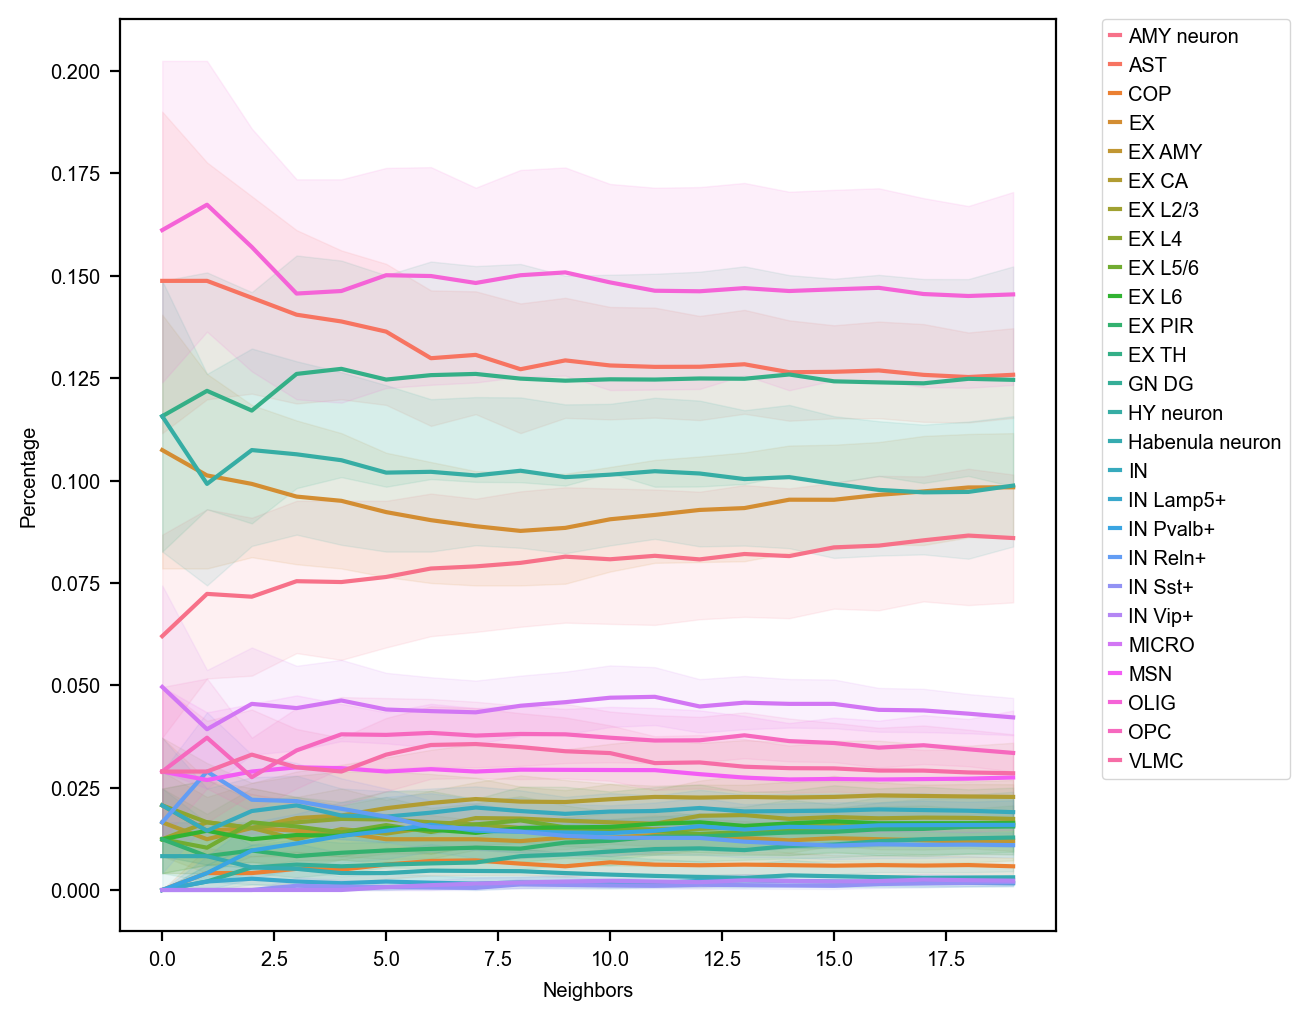

In [44]:
# Celltype co-localization (OPC and others)
# Lineplot in spateo paper

fig = plt.figure(figsize=(6, 6))
sns.lineplot(data=df_plt, x='Neighbors', y='Percentage', hue='Celltype',ci=90, err_kws={"alpha": 0.1})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

|-----> Calculating cell counts in each bin, using binsize 50
|-----> Calculating Moran's I score for each celltype


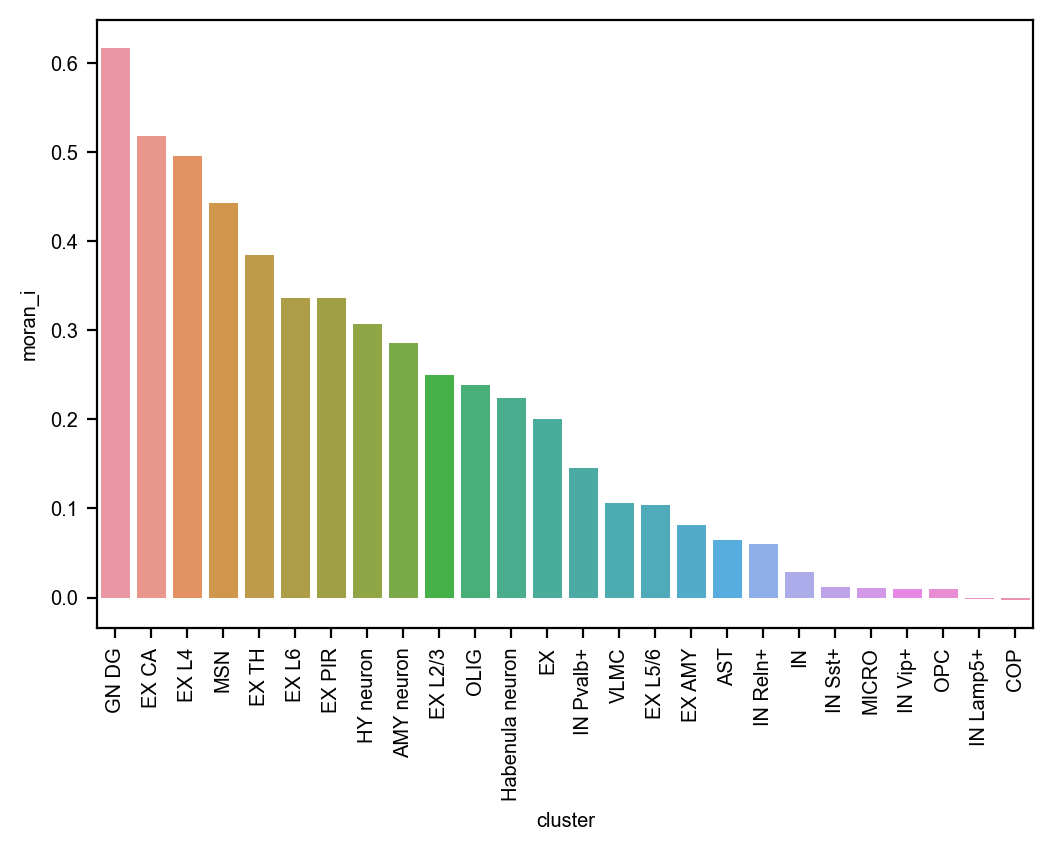

In [41]:
# Calculate Moran's I score for celltypes
moran_df = st.tl.cellbin_morani(adata_cellbin, binsize=50)
fig = sns.barplot(x='cluster',y='moran_i',data=moran_df)
_ = plt.xticks(rotation=90)

Moran’s I score 是一种用来衡量空间自相关的指标，它根据空间位置和属性值同时考虑了空间数据的分布特征。空间自相关是指空间上相邻的位置之间存在相似或不相似的信号的关联性。Moran’s I score 的取值范围在 -1.0 到 +1.0 之间，如果空间数据呈现聚集或分散的模式，Moran’s I score 会是正值或负值；如果空间数据呈现随机的模式，Moran’s I score 会接近于零。Moran’s I score 的计算和检验需要定义一个空间权重矩阵，用来表示不同位置之间的邻接关系和距离衰减函数。

反映的是细胞在空间上的聚集程度

结合space map看可以看出，GN DG这类细胞，在空间上聚集程度特别高